In [1]:
# Extract and transform MIT-BIH dataset from Zip file
!python3 extract-data.py
!python3 transform-data.py

In [2]:
import torch
from torch.utils import data
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from sklearn.metrics import f1_score, precision_score, recall_score
!jupyter nbextension enable --py widgetsnbextension
%matplotlib inline

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [3]:
# Switch to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.autograd.set_detect_anomaly(True)
if torch.cuda.is_available():
    print("Using the GPU!")
else:
    print("No GPU")

Using the GPU!


In [4]:
# Dataloader classes
class EcgDataset(Dataset):
    def __init__(self, source):
        super().__init__()

        # Load training data
        self.train_x = torch.from_numpy(np.load(f"data/{source}_x.npy")).float()
        self.train_y = torch.from_numpy(np.load(f"data/{source}_y.npy")).float()

    def __getitem__(self, index):
        return self.train_x[index], self.train_y[index]

    def __len__(self):
        return self.train_y.shape[0]

In [5]:
# Create dataloaders (change num_workers=0 if CPU only)
train_dataloader = DataLoader(
    dataset=EcgDataset("train"), batch_size=32, shuffle=True, num_workers=2, drop_last=True
)
test_dataloader = DataLoader(
    dataset=EcgDataset("test"), batch_size=32, shuffle=True, num_workers=2
)
test_dataloader_display = DataLoader(
    dataset=EcgDataset("test"), batch_size=1, shuffle=False, num_workers=2
)

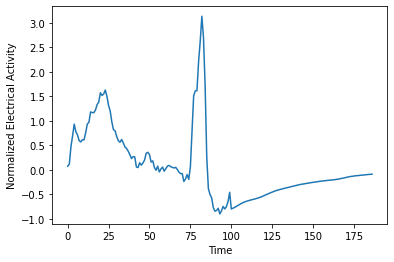

In [6]:
# Show graph of data to prove dataloaders are working
x, y = iter(test_dataloader_display).next()
plt.xlabel('Time')
plt.ylabel('Normalized Electrical Activity')
plt.plot(x[0])

In [7]:
# LSTM block to be used inside other models
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout_prob):
        super(LSTMModel, self).__init__()

        # Defining the number of layers and the nodes in each layer
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.lstm = nn.LSTM(
            input_dim, hidden_dim, num_layers, batch_first=True, bidirectional=True, dropout=dropout_prob
        )

    def forward(self, x):
        h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_dim).to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))

        return out

In [8]:
# Simple fully connected model to test accuracy against
class SimpleFullyConnected(nn.Module):
    def __init__(self):
        super(SimpleFullyConnected, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(187, 1000),
            nn.ReLU(),
            nn.BatchNorm1d(1000),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.BatchNorm1d(1000),
            nn.Linear(1000, 5),
            nn.Softmax(-1)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.reshape(batch_size, -1)

        return self.fc(x)

In [9]:
# Slightly more complex model to test accuracy against
class ConvolutionalBLSTM(nn.Module):
    def __init__(self):
        super(ConvolutionalBLSTM, self).__init__()
        # LSTM
        self.c1L = nn.Sequential(
            nn.Conv1d(1, 32, 16, stride=1, padding=0), # BxCxL -> Bx32x172
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        self.L = LSTMModel(32, 172, 1, 0.0) #BxLxC
        self.fcL = nn.Sequential(
            nn.Linear(344*172, 5),
            nn.Softmax(-1)
        )
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = x.reshape(batch_size, 1, -1)
        
        # First conv LSTM
        outL = self.c1L(x)
        outL = self.L(outL.reshape(batch_size, outL.size(2), -1))
        outL = self.fcL(outL.reshape(batch_size, -1))

        return outL

In [10]:
# HADLN model
class HADLN(nn.Module):
    def BasicBlock(self, in_channels=32, out_channels=32, kernel_size=17, stride=1, padding=8):
        return nn.Sequential(
            nn.BatchNorm1d(in_channels),
            nn.ReLU(),
            nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding),
            nn.BatchNorm1d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding)
        )
    
    def ShortcutBlock(self, in_channels=32, out_channels=64):
        return nn.Sequential(
            nn.Conv1d(in_channels, out_channels, 1, stride=2, padding=0),
            nn.BatchNorm1d(out_channels)
        )
    
    def __init__(self):
        super(HADLN, self).__init__()
        # LSTM
        self.c1L = nn.Sequential(
            nn.Conv1d(1, 32, 16, stride=1, padding=0), # BxCxL -> Bx32x172
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        self.L = LSTMModel(32, 172, 1, 0.0) #BxLxC
        self.fcL = nn.Linear(344*172, 256*18)
        
        # ResNet Precursors
        self.c1RP = nn.Sequential(
            nn.Conv1d(1, 32, 16, stride=1, padding=0),
            nn.BatchNorm1d(32),
            nn.ReLU()
        )
        
        self.c2RP = nn.Sequential(
            nn.Conv1d(32, 32, 16, stride=1, padding=0),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Conv1d(32, 32, 16, stride=1, padding=0)
        )
        
        # ResNet
        self.rb1 = self.BasicBlock()
        self.rb2 = self.BasicBlock()
        self.rb3 = self.BasicBlock()
        self.rb4 = self.BasicBlock()
        self.sc1 = self.ShortcutBlock()
        
        self.rb5 = self.BasicBlock(in_channels=32, out_channels=64, stride=2)
        self.rb6 = self.BasicBlock(in_channels=64, out_channels=64)
        self.rb7 = self.BasicBlock(in_channels=64, out_channels=64)
        self.rb8 = self.BasicBlock(in_channels=64, out_channels=64)
        self.sc2 = self.ShortcutBlock(in_channels=64, out_channels=128)
        
        self.rb9 = self.BasicBlock(in_channels=64, out_channels=128, stride=2)
        self.rb10 = self.BasicBlock(in_channels=128, out_channels=128)
        self.rb11 = self.BasicBlock(in_channels=128, out_channels=128)
        self.rb12 = self.BasicBlock(in_channels=128, out_channels=128)
        self.sc3 = self.ShortcutBlock(in_channels=128, out_channels=256)
        
        self.rb13 = self.BasicBlock(in_channels=128, out_channels=256, stride=2)
        self.rb14 = self.BasicBlock(in_channels=256, out_channels=256)
        self.rb15 = self.BasicBlock(in_channels=256, out_channels=256)
        self.rb16 = self.BasicBlock(in_channels=256, out_channels=256)
        
        # ResNet Fc
        self.fcR = nn.Linear(256*18, 256*18)
        
        # Merge LSTM and ResNet, this is attention as well
        self.merge = nn.Sequential(
            nn.Tanh(),
            nn.Linear(256*18, 256*18),
            nn.Softmax(-1)
        )
        
        # Output - time distribute
        self.classifier = nn.Sequential(
            nn.BatchNorm1d(4608),
            nn.ReLU(),
            nn.Linear(256*18, 5),
            nn.Softmax(-1)
        )
        

    def forward(self, x):
        batch_size = x.shape[0]
        x = x.reshape(batch_size, 1, -1)
        
        # First conv LSTM
        outL = self.c1L(x)
        outL = self.L(outL.reshape(batch_size, outL.size(2), -1))
        outL = self.fcL(outL.reshape(batch_size, -1))
        
        # ResNet precursors
        outR = self.c1RP(x)
        outR = self.c2RP(outR)
        
        # ResNet
        
        # 32 features
        outR = self.rb1(outR)
        outR = self.rb2(outR) + outR
        outR = self.rb3(outR) + outR
        outR = self.rb4(outR) + outR
        sc = self.sc1(outR)
        
        # 64 Features
        outR = self.rb5(outR) + sc
        outR = self.rb6(outR) + outR
        outR = self.rb7(outR) + outR
        outR = self.rb8(outR) + outR
        sc = self.sc2(outR)
        
        # 128 Features
        outR = self.rb9(outR) + sc
        outR = self.rb10(outR) + outR
        outR = self.rb11(outR) + outR
        outR = self.rb12(outR) + outR
        sc = self.sc3(outR)
        
        # 256 Features
        outR = self.rb13(outR) + sc
        outR = self.rb14(outR) + outR
        outR = self.rb15(outR) + outR
        outR = (self.rb16(outR) + outR).reshape(batch_size, -1)
        rnFeatures = outR

        # ResNet FC
        outR = self.fcR(outR)
        
        # Merge
        merge = self.merge(outL + outR)
        
        # Multiply by ResNet output
        merge = merge * rnFeatures
        
        # Classifier
        classifier = self.classifier(merge)

        return classifier

In [11]:
# Focal loss for handling extremely unbalanced datasets
# Taken from:
# https://github.com/gokulprasadthekkel/pytorch-multi-class-focal-loss/blob/master/focal_loss.py
class FocalLoss(nn.modules.loss._WeightedLoss):
    def __init__(self, weight=None, gamma=2,reduction='mean'):
        super(FocalLoss, self).__init__(weight,reduction=reduction)
        self.gamma = gamma
        self.weight = weight #weight parameter will act as the alpha parameter to balance class weights

    def forward(self, input, target):

        ce_loss = F.cross_entropy(input, target,reduction=self.reduction,weight=self.weight)
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma * ce_loss).mean()
        return focal_loss

In [12]:
def testLoss(model):
    criterion = FocalLoss(weight=torch.tensor([1-72470/87553, 1-2223/87553, 1-5788/87553, 1-641/87553, 1-6431/87553]).to(device))
    with torch.no_grad():
        loss = 0
        for i, data in enumerate(test_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # get predictions
            outputs = model(inputs)
            loss += criterion(outputs, labels).item()
        return loss

In [13]:
def train(model, epochs):
    criterion = FocalLoss(weight=torch.tensor([1-72470/87553, 1-2223/87553, 1-5788/87553, 1-641/87553, 1-6431/87553]).to(device))
    optimizer = optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)

    print(f"Training {epochs} epochs. Dataset is {len(train_dataloader)} big. Using batch size 32")
    print(f"{len(train_dataloader) // 32 + 1} minibatches are needed per epoch")
    
    train_losses = []
    test_losses = []
    min_test_loss = (0, 9999999999999)
    for epoch in range(epochs):

        running_loss = 0.0
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            if i % 1000 == 0:
                print(f"Minibatch {i+1}. Loss {loss.item()}")

        # print statistics
        print(f"Epoch {epoch}/{epochs}. Loss {running_loss}")
        test_loss = testLoss(model)
        print(f"Test loss {test_loss}")
        
        # Increment scheduler
        scheduler.step(test_loss)
        
        # Save statistics
        train_losses.append(running_loss)
        test_losses.append(test_loss)
        
        # Save model if loss low
        if test_loss < min_test_loss[1]:
            min_test_loss = (epoch, test_loss)
            torch.save(model.state_dict(), 'model.pth')
    
    return train_losses, test_losses

In [14]:
# Define model
model = HADLN().to(device)

In [22]:
# Load model
# model.load_state_dict(torch.load("model.pth", map_location=device))

In [ ]:
# Train
train_losses, test_losses = train(model, 25)

Training 25 epochs. Dataset is 2736 big. Using batch size 32
86 minibatches are needed per epoch
Minibatch 1. Loss 0.06505963951349258
Minibatch 1001. Loss 0.09028346091508865
Minibatch 2001. Loss 0.047040682286024094
Epoch 0/25. Loss 138.77292577340268
Test loss 39.36207064567134
Minibatch 1. Loss 0.06388075649738312
Minibatch 1001. Loss 0.025318395346403122
Minibatch 2001. Loss 0.08728927373886108
Epoch 1/25. Loss 133.09080529608764
Test loss 30.313013742212206
Minibatch 1. Loss 0.024825606495141983
Minibatch 1001. Loss 0.050415657460689545
Minibatch 2001. Loss 0.02548980340361595
Epoch 2/25. Loss 118.33617493161
Test loss 29.07951483828947
Minibatch 1. Loss 0.01946282759308815
Minibatch 1001. Loss 0.05616622418165207
Minibatch 2001. Loss 0.018767062574625015
Epoch 3/25. Loss 108.91111539583653
Test loss 25.01913564512506
Minibatch 1. Loss 0.04392869025468826
Minibatch 1001. Loss 0.05262960121035576
Minibatch 2001. Loss 0.06187665835022926
Epoch 4/25. Loss 89.260361823719
Test loss 2

In [ ]:
# Print loss graph
plt.plot(test_losses, label="Validation")
plt.plot(train_losses, label="Training")
plt.xlabel('Epoch')
plt.ylabel('Normalized Loss')
plt.legend()
plt.show()

In [ ]:
# Find number of misclassified validation examples
import numpy as np
with torch.no_grad():
    # Precision, accuracy, recall, f1
    precisions = []
    recalls = []
    f1 = []
    
    # Per class accuracy
    correct_by_class = [0,0,0,0,0]
    total_by_class = [0,0,0,0,0]
    for i, data in enumerate(test_dataloader, 0):
        inputs, labels = data
        inputs = inputs.to(device)
        labels = labels.to(device)

        # get predictions
        outputs = model(inputs)
        outputs[outputs < 0.5] = 0
        outputs[outputs >= 0.5] = 1
        
        # Find total by class
        total_by_class[0] += torch.where((labels[:, 0] == 1))[0].shape[0]
        total_by_class[1] += torch.where((labels[:, 1] == 1))[0].shape[0]
        total_by_class[2] += torch.where((labels[:, 2] == 1))[0].shape[0]
        total_by_class[3] += torch.where((labels[:, 3] == 1))[0].shape[0]
        total_by_class[4] += torch.where((labels[:, 4] == 1))[0].shape[0]
        
        # Find correct by class
        correct_by_class[0] += torch.where((labels[:, 0] == outputs[:, 0]) & (labels[:, 0] == 1) )[0].shape[0]
        correct_by_class[1] += torch.where((labels[:, 1] == outputs[:, 1]) & (labels[:, 1] == 1) )[0].shape[0]
        correct_by_class[2] += torch.where((labels[:, 2] == outputs[:, 2]) & (labels[:, 2] == 1) )[0].shape[0]
        correct_by_class[3] += torch.where((labels[:, 3] == outputs[:, 3]) & (labels[:, 3] == 1) )[0].shape[0]
        correct_by_class[4] += torch.where((labels[:, 4] == outputs[:, 4]) & (labels[:, 4] == 1) )[0].shape[0]
        
        # F1
        f1.append(f1_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0))
        
        # Precision
        precisions.append(precision_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0))
        
        # Recall
        recalls.append(recall_score(labels.cpu(), outputs.cpu(), average='weighted', zero_division=0))
        
# Print accuracy
print(f'Total correct: {sum(correct_by_class)} / {sum(total_by_class)}. {sum(correct_by_class) / sum(total_by_class) * 100}%')
print(f'{correct_by_class}')
print(f'{np.array(correct_by_class) / np.array(total_by_class) * 100}')
print('------')

# Print precision, recall, and f1
print(f'Weighted Precision: {sum(precisions)/len(precisions)*100}%')
print(f'Weighted Recall: {sum(recalls)/len(recalls)*100}%')
print(f'Weighted F1: {sum(f1)/len(f1)*100}%')
